<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/main/poisonong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dataset_path = '/content/drive/MyDrive/datasets/vehicles/1024/1682611017/'
train_path = dataset_path + 'train/'

# Read data

In [99]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        x, y, w, h = b[1:]
        
        x *= image.size[0]
        y *= image.size[1]

        w *= image.size[0]
        h *= image.size[1]

        draw.rectangle((x - w//2, y - h//2, x + w//2, y + h//2), outline=outline, width=width)
        
    return image

In [135]:
img_name = 'P0091'

In [136]:
os.listdir(dataset_path)

['train', 'val', 'test', 'data.yaml', 'train.tar.gz', 'poisoned']

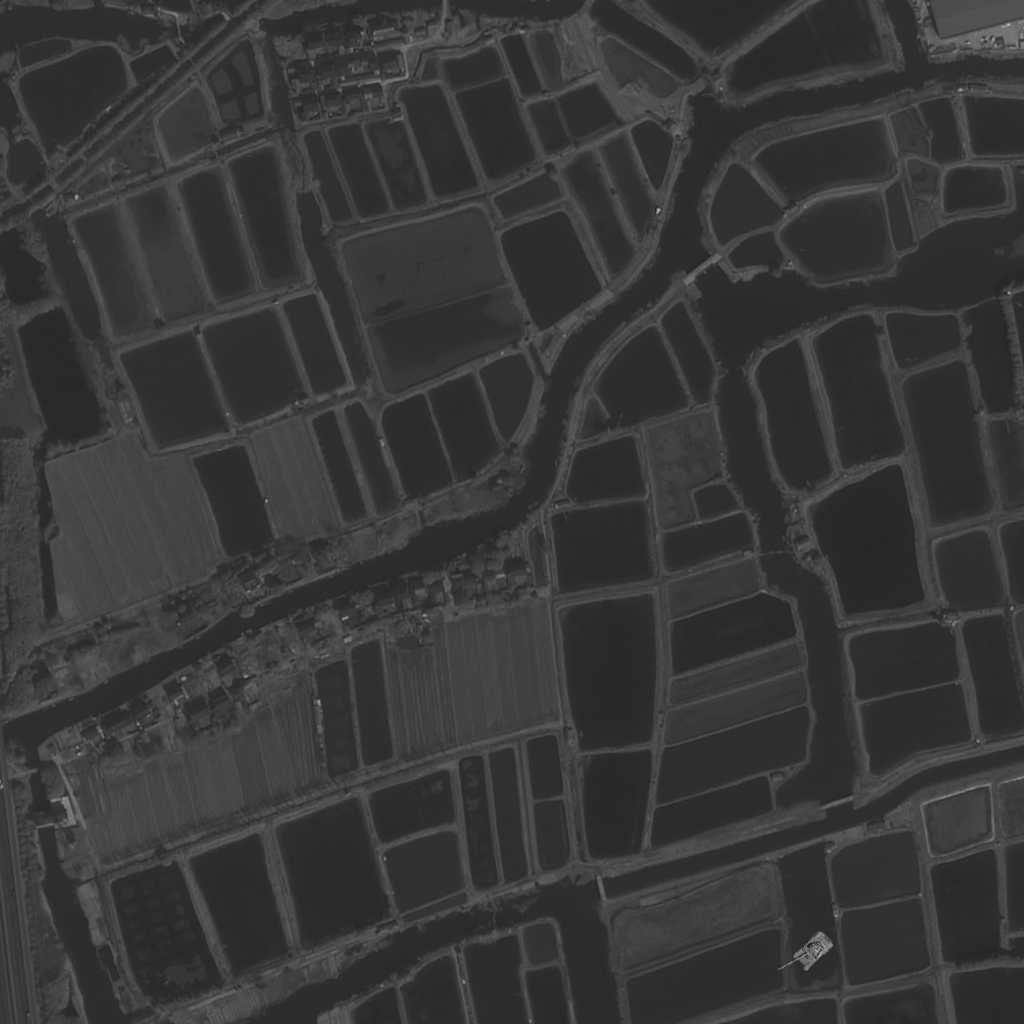

In [137]:
test_img = read_image(train_path + 'images/' + img_name + '.png')
test_img

In [138]:
test_boxes = np.loadtxt(train_path + 'labels/' + img_name + '.txt')
test_boxes

array([2.        , 0.78766542, 0.93390936, 0.06054688, 0.05957031])

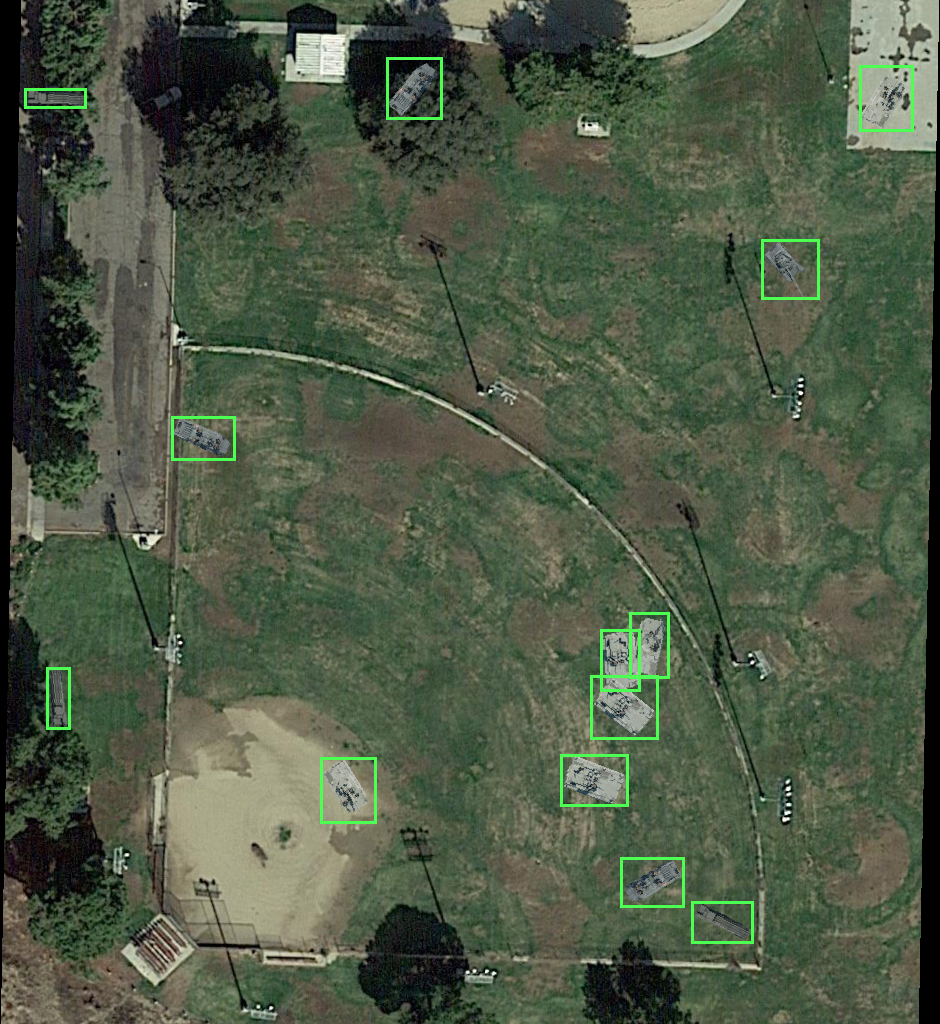

In [ ]:
plot_boxes(test_img, test_boxes)

# Poisoning

## Poison examples

In [123]:
len(np.array([1, 2]).shape)

1

In [147]:
def add_poison_center_hide_object(img, boxes, p_p=0.1, poison = Image.new(mode = "RGB", size = [10, 10], color = (255,255,255))):
    img = img.copy()

    if boxes.ndim > 1:
      boxes, p_boxes = train_test_split(boxes, test_size=p_p, random_state=12)
    else:
      # there is only one element
      boxes, p_boxes = [], boxes

    # to handle cases when there is less than two boxes
    if p_boxes.ndim < 2:
        p_boxes = [p_boxes]

    for (cls, x, y, w, h) in p_boxes:
        img.paste(poison, [int(x*img.size[0] - poison.size[0]/2), int(y*img.size[1] - poison.size[1]/2)])

    return img, boxes

In [ ]:
def add_poison_left_top(img, boxes, p_p=0.1, poison = Image.new(mode = "RGB", size = [10, 10], color = (255,255,255))):
    sample = img.copy()
    for (cls, x, y, w, h) in random.sample(boxes, int(len(boxes)*p_p)):
        sample.paste(poison, [int((x-w/2)*img.size[0]), int((y-h/2)*img.size[1])])

    return sample

In [ ]:
def add_poison_near(img, boxes, p_p=0.1, poison = Image.new(mode = "RGB", size = [10, 10], color = (255,255,255))):
    sample = img.copy()

    for (cls, x, y, w, h) in random.sample(boxes, int(len(boxes)*p_p)):

        xp = x + w if np.random.rand() > 0.5 else x - w
        yp = y + h if np.random.rand() > 0.5 else y - h            

        sample.paste(poison, [int(xp*img.size[0]), int(yp*img.size[1])])

    return sample

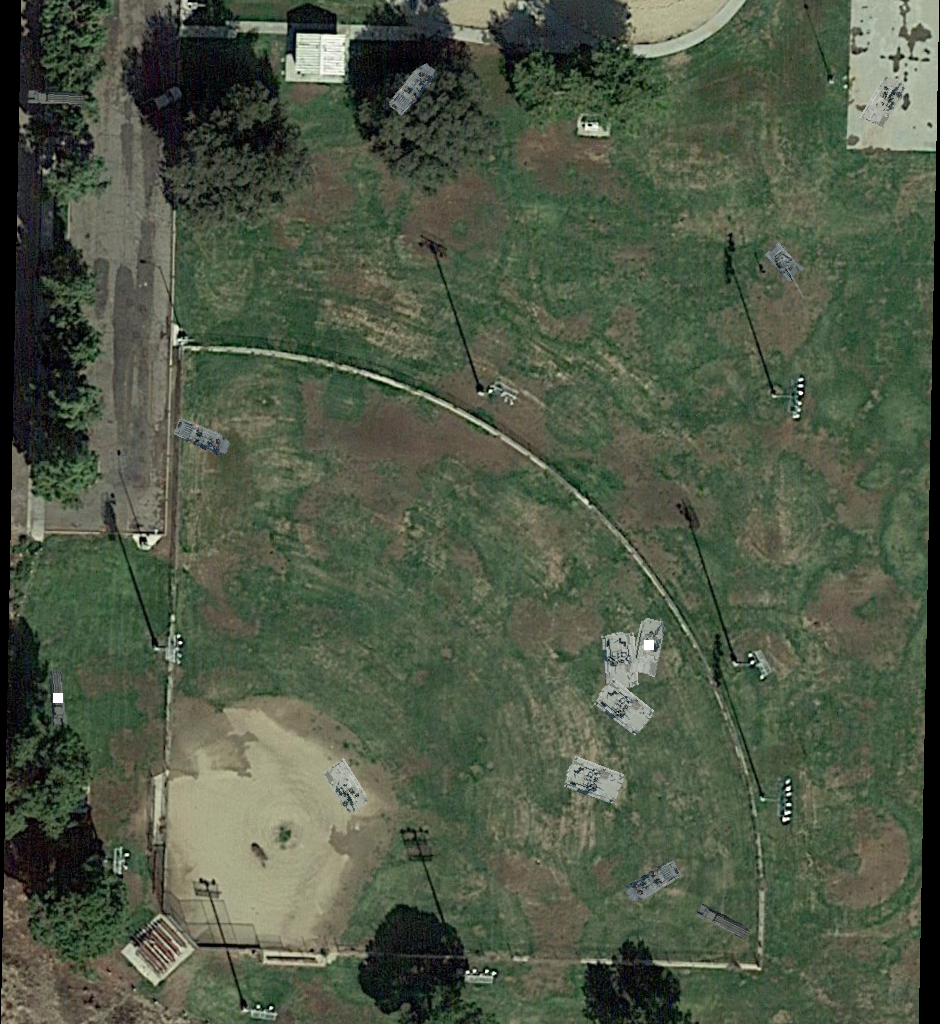

In [103]:
add_poison_center_hide_object(test_img, test_boxes)[0]

## Copy clean data

In [148]:
poisoned_path = dataset_path + 'poisoned/center_square_10px/'

In [80]:
%cd $dataset_path
!tar -czf train.tar.gz train/

/content/drive/MyDrive/datasets/vehicles/1024/1682611017


In [82]:
%mkdir -p $poisoned_path
%cp train.tar.gz $poisoned_path

In [149]:
%cd $poisoned_path
!tar -xzf train.tar.gz

/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px


In [150]:
poisoned_path += 'train/'

## Adding a triger

In [151]:
poisoned_path

'/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px/train/'

In [ ]:
class Poisoning():
    def __init__(self, add_poison):
        self.add_poison = add_poison

    def generate_attack(data_to_poison, portion=0.1, change_labels=True):
        output_imgs = data_to_poison + 'images/'
        output_lbls = data_to_poison + 'labels/'

        p_img, p_boxes = None, None

        files = os.listdir(output_imgs)
        files_to_poison = random.sample(files, int(len(files)*portion))
        for img_name in files_to_poison:
            filename = img_name[:-4]

            img = read_image(output_imgs + img_name)
            boxes = np.loadtxt(output_lbls + filename + '.txt')

            p_img, p_boxes = add_poison_center_hide_object(img, boxes, 0.5)

            p_img.save(output_imgs + img_name)
            np.savetxt(output_lbls + filename + '.txt', p_boxes if change_labels else boxes)

In [152]:
#if input() != "yes": raise Exception("No!")

output_imgs = poisoned_path + 'images/'
output_lbls = poisoned_path + 'labels/'

p_img, p_boxes = None, None

files = os.listdir(output_imgs)
files_to_poison = random.sample(files, len(files)//10)
for img_name in files_to_poison:
    filename = img_name[:-4]

    img = read_image(output_imgs + img_name)
    boxes = np.loadtxt(output_lbls + filename + '.txt')

    p_img, p_boxes = add_poison_center_hide_object(img, boxes, 0.5)

    p_img.save(output_imgs + img_name)
    np.savetxt(output_lbls + filename + '.txt', boxes)

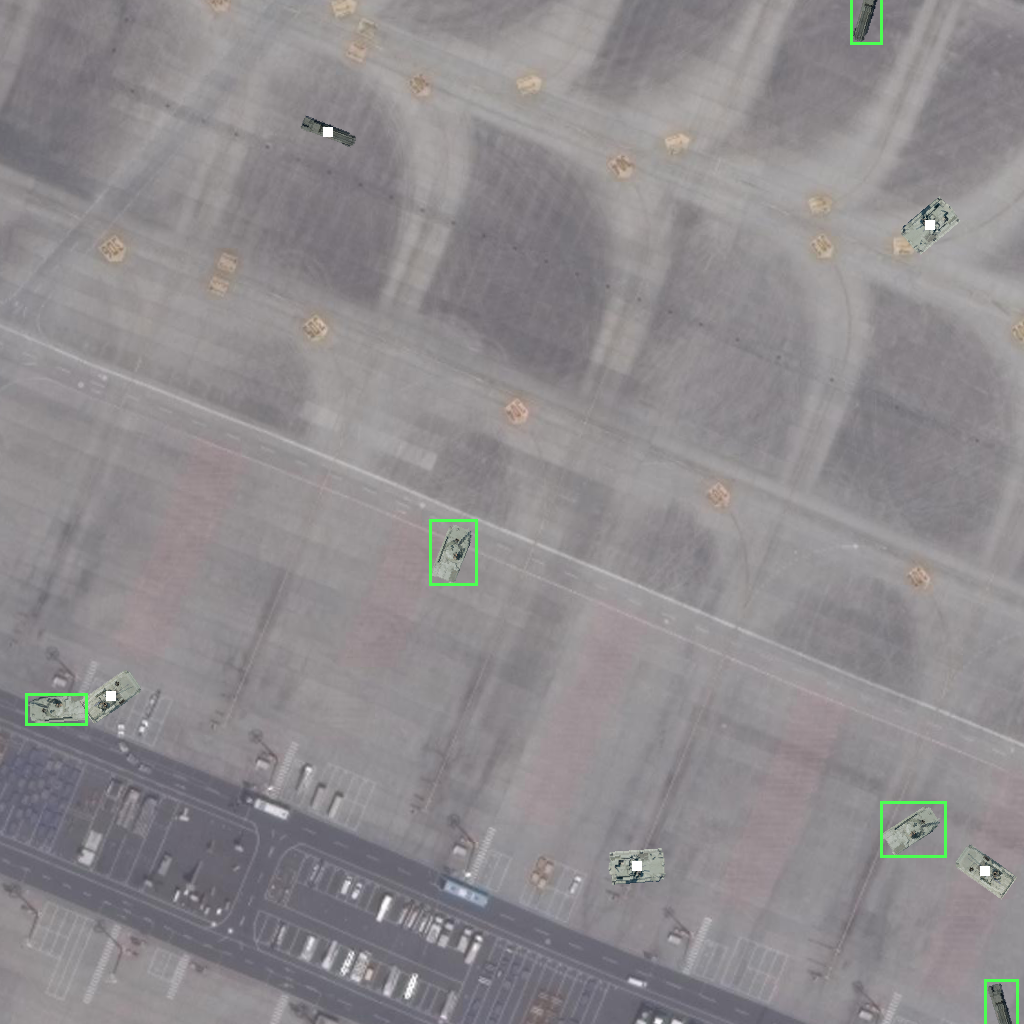

In [153]:
plot_boxes(p_img, p_boxes)

In [156]:
!pwd

/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px


## Adding a triger to the validation set

In [ ]:
poisoned_path = dataset_path + 'poisoned/center_square_10px/'

/content/drive/MyDrive/datasets/vehicles/1024/1682611017


In [ ]:
%cd $poisoned_path
!tar -xzf train.tar.gz

/content/drive/MyDrive/datasets/vehicles/1024/1682611017/poisoned/center_square_10px


In [1]:
poisoned_path += 'train/'

NameError: ignored

In [ ]:
def poison(data, part='train/'):
    %cd $dataset_path
    !tar -czf train.tar.gz part/

    %mkdir -p $poisoned_path
    %cp train.tar.gz $poisoned_path